# Smart_Traffic_Light_Control

In [14]:
import os, random, time, json, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from collections import deque

# Config / Constants


In [15]:

SEED = 7
random.seed(SEED); np.random.seed(SEED)
CSP_MAX_ITERS = 300        # tuneable
DQN_EPISODES = 800        # tuneable (increase for stronger learning)
BATCH = 8                 # intersections per scenario
ACTION_SET = np.array([20,30,40,50,60,70,80,90,100])

# File paths (assumes files uploaded into working dir)
AADT_FILE = 'Annual_Average_Daily_Traffic_-_MDOT_SHA_Statewide_AADT_Points.csv'
SIGNAL_FILE = 'Traffic_Signal.csv'

# Utility functions

In [16]:
def assert_files_exist():
    missing = [f for f in (AADT_FILE, SIGNAL_FILE) if not os.path.exists(f)]
    if missing:
        raise FileNotFoundError(f"Required files missing: {missing}")

# Load & quick inspect

In [17]:
assert_files_exist()
aadt = pd.read_csv(AADT_FILE)
signals = pd.read_csv(SIGNAL_FILE)
print(f"Loaded AADT: {aadt.shape}, Signals: {signals.shape}")
print("Sample AADT columns:", list(aadt.columns[:8]))
print("Sample Signals columns:", list(signals.columns[:8]))
print("✅ File loading complete.")

Loaded AADT: (8773, 101), Signals: (557, 7)
Sample AADT columns: ['the_geom', 'GIS Object ID', 'Location ID', 'County Code', 'County Name', 'Municipal Code', 'Municipality Name', 'Road Name']
Sample Signals columns: ['TSI NO', 'MAINTAINED BY', 'PRIMARY STREET NAME', 'SECONDARY STREET NAME', 'SIGNAL TYPE', 'PEDESTRIAN SIGNAL', 'GEOLOCATION']
✅ File loading complete.



# Cleaning / Imputation


In [18]:
def clean_df(df, drop_frac=0.85):
    df = df.copy()
    df.drop_duplicates(inplace=True)
    # drop overly sparse columns
    drop_cols = df.columns[df.isna().mean() > drop_frac].tolist()
    if drop_cols:
        df = df.drop(columns=drop_cols)
    # numeric median impute
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
    # categorical fill
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    for c in cat_cols:
        if df[c].isna().any():
            mode = df[c].mode(dropna=True)
            df[c].fillna(mode.iloc[0] if not mode.empty else 'NA', inplace=True)
    return df

start = time.time()
aadt_c = clean_df(aadt)
signals_c = clean_df(signals)
end = time.time()
print(f"✅ Cleaning complete. AADT -> {aadt_c.shape}, Signals -> {signals_c.shape}; took {end-start:.2f}s")

✅ Cleaning complete. AADT -> (8773, 97), Signals -> (557, 7); took 0.29s


# Merge logic 

In [19]:
common = set(aadt_c.columns).intersection(set(signals_c.columns))
merge_key = None
for c in common:
    if any(k in c.lower() for k in ['id','signal','location','objectid']):
        merge_key = c
        break

if merge_key:
    merged = pd.merge(signals_c, aadt_c, on=merge_key, how='left', suffixes=('_sig','_aadt'))
    print(f"✅ Merged on key: {merge_key}. Merged shape: {merged.shape}")
else:
    # try nearest neighbor by coordinates
    a_lat = next((c for c in aadt_c.columns if 'lat' in c.lower()), None)
    a_lon = next((c for c in aadt_c.columns if 'lon' in c.lower() or 'long' in c.lower()), None)
    s_lat = next((c for c in signals_c.columns if 'lat' in c.lower()), None)
    s_lon = next((c for c in signals_c.columns if 'lon' in c.lower() or 'long' in c.lower()), None)
    if a_lat and a_lon and s_lat and s_lon:
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=1).fit(aadt_c[[a_lat,a_lon]].values)
        dists, idxs = nbrs.kneighbors(signals_c[[s_lat,s_lon]].values)
        matched = aadt_c.iloc[idxs.flatten()].reset_index(drop=True)
        merged = pd.concat([signals_c.reset_index(drop=True), matched.add_suffix('_aadt')], axis=1)
        print(f"✅ Merged by nearest coordinates. Merged shape: {merged.shape}")
    else:
        merged = pd.concat([signals_c.reset_index(drop=True), aadt_c.reset_index(drop=True)], axis=1)
        print(f"⚠️ Fallback horizontal concat. Merged shape: {merged.shape}")

# end of merge cell
print(f"✅ Merge step finished. Final merged shape: {merged.shape}")

⚠️ Fallback horizontal concat. Merged shape: (8773, 104)
✅ Merge step finished. Final merged shape: (8773, 104)


# Feature extraction

In [20]:
numeric = merged.select_dtypes(include=[np.number]).copy()
# drop obvious index/object id numbers
drop_like = [c for c in numeric.columns if any(x in c.lower() for x in ['objectid','index','gid'])]
numeric.drop(columns=[c for c in drop_like if c in numeric.columns], inplace=True, errors='ignore')

# find AADT-like column
aadt_candidates = [c for c in numeric.columns if 'aadt' in c.lower() or 'daily' in c.lower() or 'volume' in c.lower() or 'traffic' in c.lower()]
if aadt_candidates:
    numeric['volume'] = numeric[aadt_candidates[0]]
else:
    numeric['volume'] = numeric.sum(axis=1)

# green time candidate
green_candidates = [c for c in numeric.columns if 'green' in c.lower() or 'cycle' in c.lower() or 'phase' in c.lower()]
if green_candidates:
    numeric['green_time'] = numeric[green_candidates[0]]
else:
    numeric['green_time'] = 60.0

features = numeric[['volume','green_time']].astype(float).reset_index(drop=True)
print(f"✅ Feature extraction complete. Features shape: {features.shape}; columns: {list(features.columns)}")

✅ Feature extraction complete. Features shape: (8773, 2); columns: ['volume', 'green_time']


# 5) Train/Test split (80/20 intersections)

In [21]:
train_idx, test_idx = train_test_split(features.index.values, test_size=0.2, random_state=SEED)
train_df = features.loc[train_idx].reset_index(drop=True)
test_df  = features.loc[test_idx].reset_index(drop=True)
print(f"✅ Train/Test split done. Train: {train_df.shape[0]} intersections, Test: {test_df.shape[0]} intersections")

✅ Train/Test split done. Train: 7018 intersections, Test: 1755 intersections


# Environment & cost definition

In [22]:
def compute_queue(volume, green_time):
    # non-linear capacity model
    return volume / (green_time**0.9 + 1e-6)

def total_cost(green_times, volumes, neighbor_pairs=None, neighbor_penalty=0.05):
    q = np.array([compute_queue(v,g) for v,g in zip(volumes, green_times)])
    cost = q.sum()
    if neighbor_pairs is not None:
        for (i,j) in neighbor_pairs:
            cost += neighbor_penalty * abs(green_times[i]-green_times[j]) / (np.mean(green_times)+1e-6)
    return cost

print("✅ Environment / cost functions defined.")

✅ Environment / cost functions defined.


# Multi-Agent CSP (local search) implementation

In [23]:
def make_neighbors(n):
    return [(i,i+1) for i in range(n-1)]

def multi_agent_csp(volumes, init_green=None, max_iters=CSP_MAX_ITERS, actions=ACTION_SET):
    n = len(volumes)
    green = np.array(init_green).astype(float) if init_green is not None else np.full(n, 60.0)
    neighbors = make_neighbors(n)
    history = []
    for it in range(max_iters):
        current_cost = total_cost(green, volumes, neighbor_pairs=neighbors)
        history.append(current_cost)
        improved = False
        order = list(range(n))
        random.shuffle(order)
        for i in order:
            best_g = green[i]
            best_cost = current_cost
            for a in actions:
                cand = green.copy(); cand[i] = a
                c = total_cost(cand, volumes, neighbor_pairs=neighbors)
                if c < best_cost - 1e-9:
                    best_cost = c; best_g = a
            if best_g != green[i]:
                green[i] = best_g
                improved = True
                current_cost = best_cost
        if not improved:
            break
    return green, history

print(f"✅ CSP implementation ready (max_iters={CSP_MAX_ITERS}).")

✅ CSP implementation ready (max_iters=300).


# Generate scenarios (batches) and run CSP on training scenarios

In [24]:

def batch_scenarios(df, batch_size=BATCH):
    scenarios = []
    for start in range(0, df.shape[0], batch_size):
        batch = df.iloc[start:start+batch_size]
        if batch.shape[0] < 2: continue
        scenarios.append(batch.reset_index(drop=True))
    return scenarios

train_scenarios = batch_scenarios(train_df, batch_size=BATCH)
test_scenarios  = batch_scenarios(test_df, batch_size=BATCH)
print(f"Scenarios: Train={len(train_scenarios)}, Test={len(test_scenarios)}")

csp_results = []
start = time.time()
for scen_idx, scen in enumerate(train_scenarios):
    vols = scen['volume'].values; init = scen['green_time'].values
    sol, hist = multi_agent_csp(vols, init_green=init)
    csp_results.append({'volumes':vols, 'init':init, 'sol':sol, 'history':hist})
end = time.time()
print(f"✅ CSP training (local search) completed on {len(csp_results)} scenarios in {end-start:.1f}s")

Scenarios: Train=878, Test=220
✅ CSP training (local search) completed on 878 scenarios in 12.6s


# Evaluate CSP on test scenarios

In [25]:

csp_test_metrics = []
for scen in test_scenarios:
    vols = scen['volume'].values; init = scen['green_time'].values
    sol, hist = multi_agent_csp(vols, init_green=init)
    init_cost = total_cost(init, vols, neighbor_pairs=make_neighbors(len(vols)))
    sol_cost = total_cost(sol, vols, neighbor_pairs=make_neighbors(len(vols)))
    csp_test_metrics.append({'init_cost':init_cost, 'sol_cost':sol_cost, 'improvement': init_cost - sol_cost})
print(f"✅ CSP evaluation on test scenarios complete. Evaluated: {len(csp_test_metrics)} scenarios")

✅ CSP evaluation on test scenarios complete. Evaluated: 220 scenarios


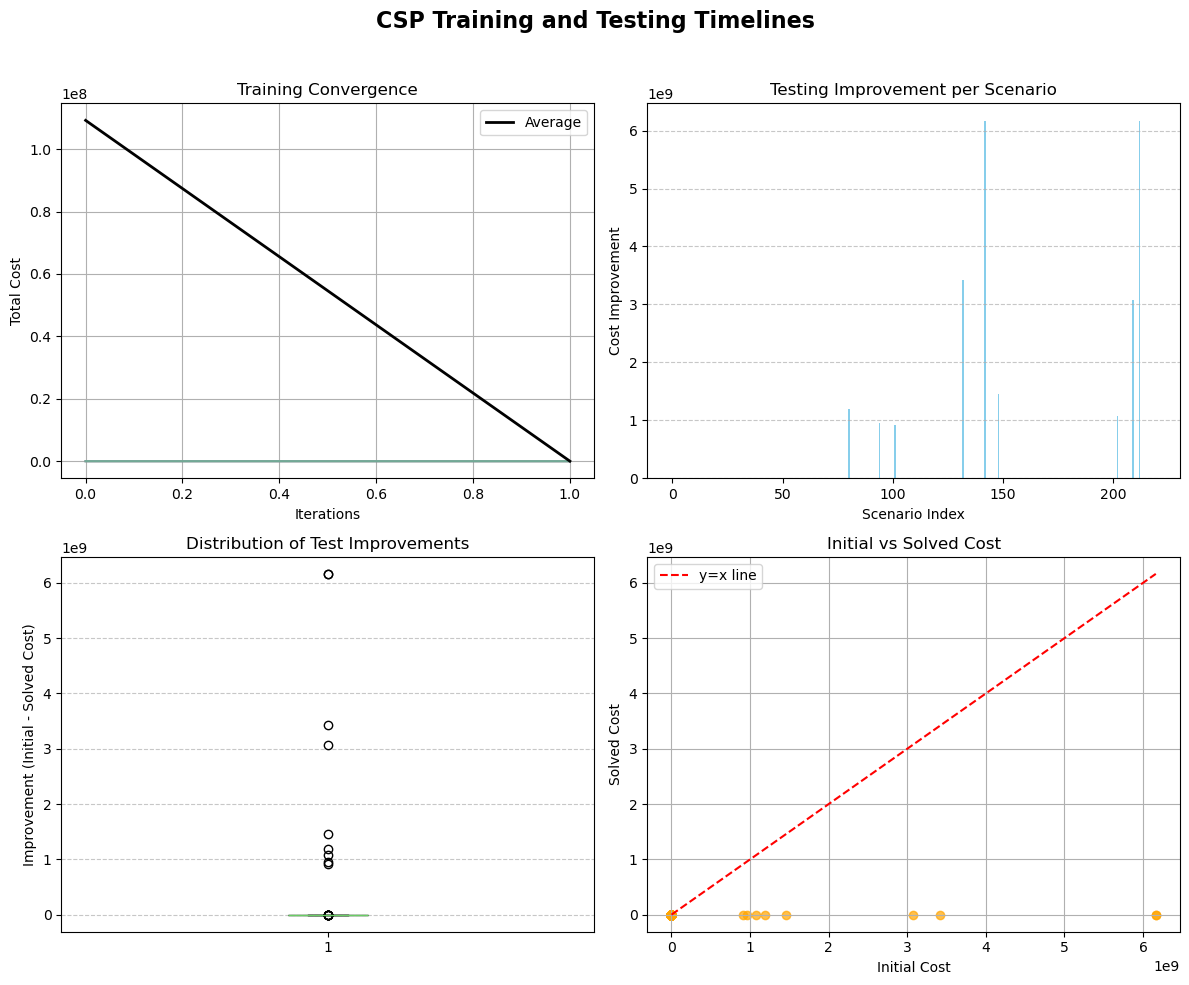

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# ====================================
# CSP TRAINING & TESTING VISUALIZATION
# ====================================
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("CSP Training and Testing Timelines", fontsize=16, fontweight='bold')

# -------------------------------
# (1) Training Convergence Timeline
# -------------------------------
if csp_results:
    max_len = max(len(r['history']) for r in csp_results)
    hist_matrix = np.array([
        np.pad(r['history'], (0, max_len - len(r['history'])), mode='edge')
        for r in csp_results
    ])
    avg_history = hist_matrix.mean(axis=0)

    for r in csp_results[:8]:
        axs[0, 0].plot(r['history'], alpha=0.4)
    axs[0, 0].plot(avg_history, color='black', linewidth=2, label='Average')
    axs[0, 0].set_title("Training Convergence")
    axs[0, 0].set_xlabel("Iterations")
    axs[0, 0].set_ylabel("Total Cost")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

# -------------------------------
# (2) Testing Improvement per Scenario
# -------------------------------
if csp_test_metrics:
    improvements = [m['improvement'] for m in csp_test_metrics]
    init_costs = [m['init_cost'] for m in csp_test_metrics]
    sol_costs = [m['sol_cost'] for m in csp_test_metrics]

    axs[0, 1].bar(range(len(improvements)), improvements, color='skyblue')
    axs[0, 1].set_title("Testing Improvement per Scenario")
    axs[0, 1].set_xlabel("Scenario Index")
    axs[0, 1].set_ylabel("Cost Improvement")
    axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# -------------------------------
# (3) Improvement Distribution
# -------------------------------
axs[1, 0].boxplot(improvements, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1, 0].set_title("Distribution of Test Improvements")
axs[1, 0].set_ylabel("Improvement (Initial - Solved Cost)")
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# -------------------------------
# (4) Initial vs Solved Cost
# -------------------------------
axs[1, 1].scatter(init_costs, sol_costs, color='orange', alpha=0.7)
axs[1, 1].plot([min(init_costs), max(init_costs)],
               [min(init_costs), max(init_costs)], 'r--', label='y=x line')
axs[1, 1].set_title("Initial vs Solved Cost")
axs[1, 1].set_xlabel("Initial Cost")
axs[1, 1].set_ylabel("Solved Cost")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Deep Q-Learning baseline (independent agents per position)

In [26]:
class DQNAgent:
    def __init__(self, state_dim=2, n_actions=len(ACTION_SET), seed=SEED):
        self.net = MLPRegressor(hidden_layer_sizes=(128,128), max_iter=1, warm_start=True, random_state=seed)
        # initial dummy fit
        self.net.fit(np.zeros((1,state_dim)), np.zeros((1,n_actions)))
        self.replay = deque(maxlen=8000)
        self.epsilon = 0.6; self.min_epsilon = 0.05; self.eps_decay = 0.995; self.gamma = 0.95

    def act(self, s):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(ACTION_SET))
        q = self.net.predict(s.reshape(1,-1))[0]
        return int(np.argmax(q))

    def store(self, s,a,r,s2,done):
        self.replay.append((s,a,r,s2,done))

    def train(self, batch_size=64):
        if len(self.replay) < batch_size:
            return
        import random as pyrandom
        batch = pyrandom.sample(self.replay, batch_size)
        X = []; Y = []
        for s,a,r,s2,done in batch:
            q = self.net.predict(s.reshape(1,-1))[0]
            if done:
                q[a] = r
            else:
                q_next = self.net.predict(s2.reshape(1,-1))[0]
                q[a] = r + self.gamma * np.max(q_next)
            X.append(s); Y.append(q)
        self.net.fit(np.array(X), np.array(Y))
        self.epsilon = max(self.min_epsilon, self.epsilon * self.eps_decay)

print("✅ DQN agent class defined.")

# initialize agents per position
agents = [DQNAgent(state_dim=2, n_actions=len(ACTION_SET), seed=SEED+i) for i in range(BATCH)]

# normalization stats
train_mean = train_df['volume'].mean(); train_std = train_df['volume'].std()+1e-9
gmean = train_df['green_time'].mean(); gstd = train_df['green_time'].std()+1e-9

def normalize(v,m,s): return (v-m)/(s+1e-9)

# Training loop
episode_rewards = []
start = time.time()
for ep in range(DQN_EPISODES):
    scen = random.choice(train_scenarios) if train_scenarios else train_df.sample(n=BATCH, replace=True)
    vols = scen['volume'].values; init = scen['green_time'].values
    if len(vols) < BATCH:
        pad = BATCH - len(vols)
        vols = np.concatenate([vols, np.zeros(pad)])
        init = np.concatenate([init, np.full(pad, 60.0)])
    vol_n = normalize(vols, train_mean, train_std); green_n = normalize(init, gmean, gstd)
    states = np.vstack([vol_n, green_n]).T
    actions_idx = [agents[i].act(states[i]) for i in range(BATCH)]
    chosen = ACTION_SET[actions_idx]
    queues = np.array([compute_queue(v,g) for v,g in zip(vols, chosen)])
    rewards = -queues
    episode_rewards.append(rewards.sum())
    next_green_n = normalize(chosen, gmean, gstd); next_states = np.vstack([vol_n, next_green_n]).T
    for i in range(BATCH):
        agents[i].store(states[i], actions_idx[i], rewards[i], next_states[i], True)
    # train agents
    for a in agents:
        a.train(batch_size=64)
end = time.time()
print(f"✅ DQN training finished. Episodes={len(episode_rewards)}; time={end-start:.1f}s; last_episode_reward={episode_rewards[-1]:.3f}")

✅ DQN agent class defined.
✅ DQN training finished. Episodes=800; time=115.1s; last_episode_reward=-2817.734


# Evaluate DQN on test scenarios

In [27]:
dqn_test_metrics = []
for scen in test_scenarios:
    vols = scen['volume'].values; init = scen['green_time'].values
    if len(vols) < BATCH:
        pad = BATCH - len(vols)
        vols = np.concatenate([vols, np.zeros(pad)])
        init = np.concatenate([init, np.full(pad, 60.0)])
    vol_n = normalize(vols, train_mean, train_std); green_n = normalize(init, gmean, gstd)
    states = np.vstack([vol_n, green_n]).T
    actions_idx = [int(np.argmax(agents[i].net.predict(states[i].reshape(1,-1))[0])) for i in range(BATCH)]
    chosen = ACTION_SET[actions_idx][:scen.shape[0]]
    init = init[:scen.shape[0]]; vols = vols[:scen.shape[0]]
    init_cost = total_cost(init, vols, neighbor_pairs=make_neighbors(len(vols)))
    dqn_cost = total_cost(chosen, vols, neighbor_pairs=make_neighbors(len(vols)))
    dqn_test_metrics.append({'init_cost':init_cost, 'dqn_cost':dqn_cost, 'improvement': init_cost - dqn_cost})

print(f"✅ DQN evaluation complete. Test scenarios evaluated: {len(dqn_test_metrics)}")

✅ DQN evaluation complete. Test scenarios evaluated: 220


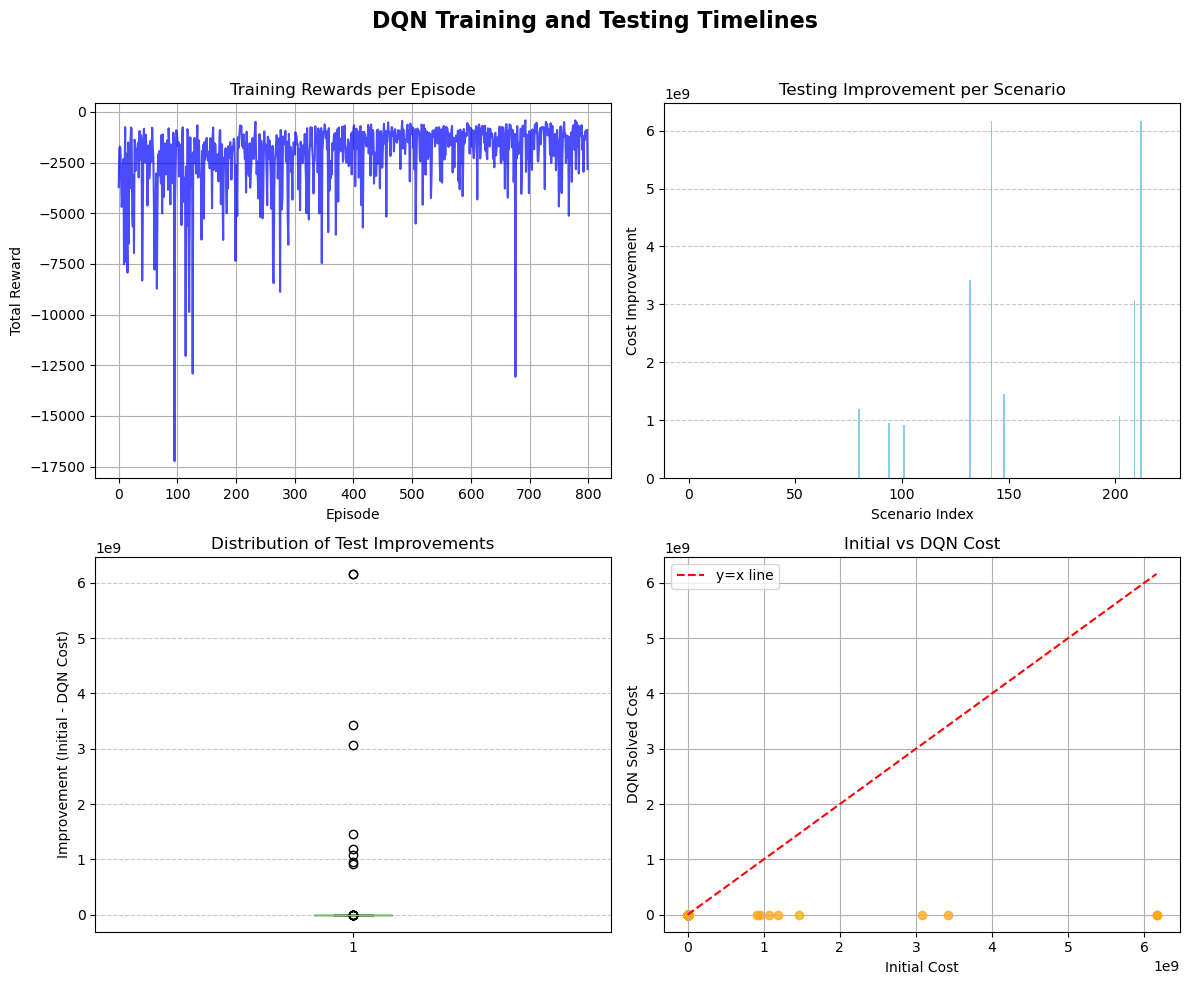

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# ====================================
# DQN TRAINING & TESTING VISUALIZATION
# ====================================
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("DQN Training and Testing Timelines", fontsize=16, fontweight='bold')

# -------------------------------
# (1) Training Reward Timeline
# -------------------------------
if episode_rewards:
    axs[0, 0].plot(episode_rewards, color='blue', alpha=0.7)
    axs[0, 0].set_title("Training Rewards per Episode")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].grid(True)

# -------------------------------
# (2) Testing Improvement per Scenario
# -------------------------------
if dqn_test_metrics:
    improvements = [m['improvement'] for m in dqn_test_metrics]
    init_costs = [m['init_cost'] for m in dqn_test_metrics]
    dqn_costs = [m['dqn_cost'] for m in dqn_test_metrics]

    axs[0, 1].bar(range(len(improvements)), improvements, color='skyblue')
    axs[0, 1].set_title("Testing Improvement per Scenario")
    axs[0, 1].set_xlabel("Scenario Index")
    axs[0, 1].set_ylabel("Cost Improvement")
    axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# -------------------------------
# (3) Improvement Distribution
# -------------------------------
axs[1, 0].boxplot(improvements, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1, 0].set_title("Distribution of Test Improvements")
axs[1, 0].set_ylabel("Improvement (Initial - DQN Cost)")
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# -------------------------------
# (4) Initial vs DQN Cost
# -------------------------------
axs[1, 1].scatter(init_costs, dqn_costs, color='orange', alpha=0.7)
axs[1, 1].plot([min(init_costs), max(init_costs)],
               [min(init_costs), max(init_costs)], 'r--', label='y=x line')
axs[1, 1].set_title("Initial vs DQN Cost")
axs[1, 1].set_xlabel("Initial Cost")
axs[1, 1].set_ylabel("DQN Solved Cost")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Summaries + Visualizations 

✅ CSP convergence plot displayed. History length: 2
✅ DQN reward plot displayed. Episodes: 800; smoothed window=50
✅ Comparison chart displayed. Avg CSP improvement: 110961690.9951; Avg DQN improvement: 110961532.1420


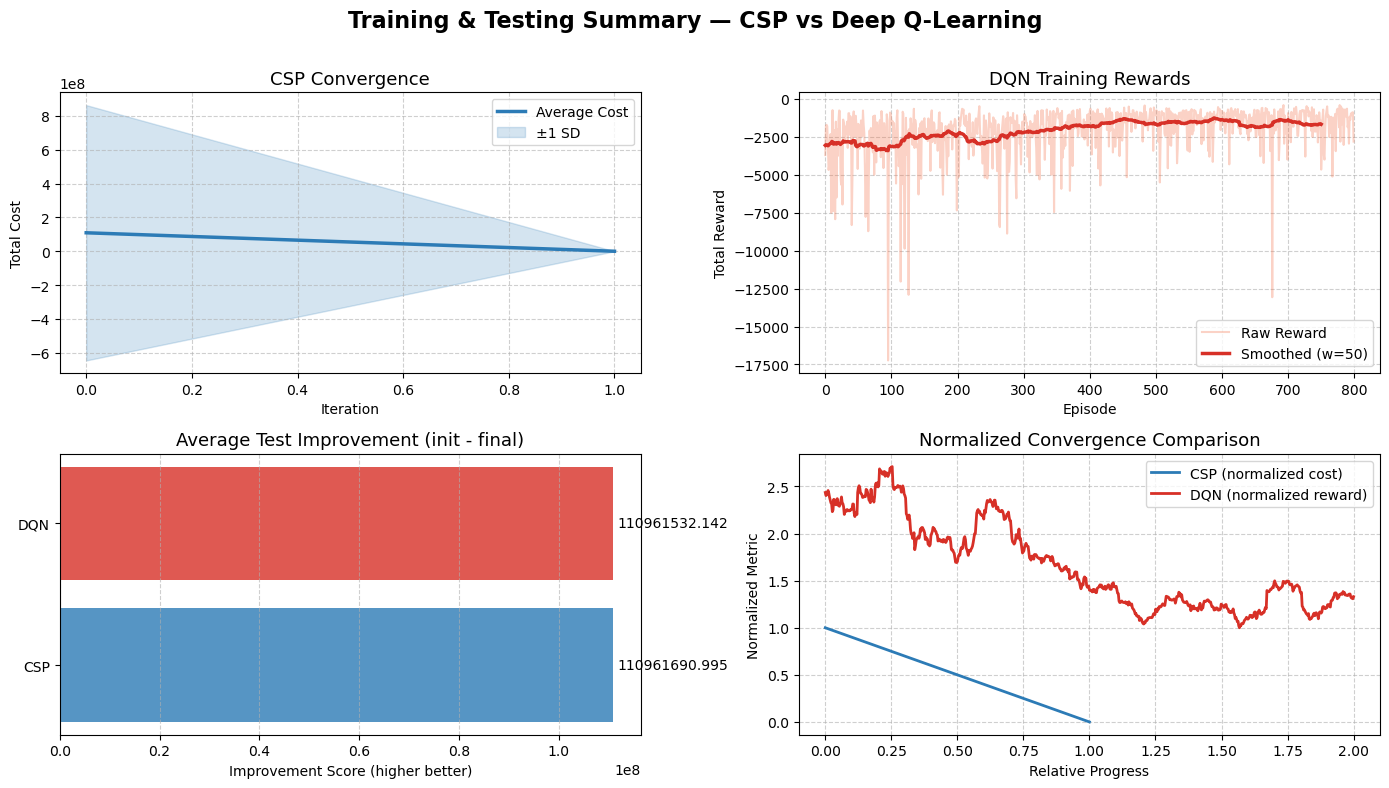

✅ Visualization summary complete.


In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-muted')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("Training & Testing Summary — CSP vs Deep Q-Learning", fontsize=16, fontweight='bold')

# --- CSP: Average convergence curve ---
if csp_results:
    max_len = max(len(r['history']) for r in csp_results)
    hist_matrix = np.array([
        np.pad(r['history'], (0, max_len - len(r['history'])), mode='edge')
        for r in csp_results
    ])
    avg_history = hist_matrix.mean(axis=0)
    std_history = hist_matrix.std(axis=0)

    ax = axes[0, 0]
    ax.plot(avg_history, color='#2C7BB6', linewidth=2.5, label='Average Cost')
    ax.fill_between(range(len(avg_history)),
                    avg_history - std_history,
                    avg_history + std_history,
                    color='#2C7BB6', alpha=0.2, label='±1 SD')
    ax.set_title('CSP Convergence', fontsize=13)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Cost')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    print(f"✅ CSP convergence plot displayed. History length: {len(avg_history)}")
else:
    axes[0, 0].text(0.5, 0.5, "No CSP data", ha='center', va='center', fontsize=12)
    print("⚠️ No CSP histories to plot.")

# --- DQN: Episode reward (smoothed) ---
def smooth(x, w=30):
    if len(x) < w:
        return np.array(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

ax = axes[0, 1]
if len(episode_rewards) > 0:
    sr = smooth(episode_rewards, w=50)
    ax.plot(episode_rewards, alpha=0.3, color='#F46D43', label='Raw Reward')
    ax.plot(range(len(sr)), sr, color='#D73027', linewidth=2.5, label='Smoothed (w=50)')
    ax.set_title('DQN Training Rewards', fontsize=13)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    print(f"✅ DQN reward plot displayed. Episodes: {len(episode_rewards)}; smoothed window=50")
else:
    ax.text(0.5, 0.5, "No DQN rewards", ha='center', va='center', fontsize=12)
    print("⚠️ No DQN rewards to plot.")

# --- Test comparison: Average improvement ---
avg_csp_impr = np.mean([m['improvement'] for m in csp_test_metrics]) if csp_test_metrics else float('nan')
avg_dqn_impr = np.mean([m['improvement'] for m in dqn_test_metrics]) if dqn_test_metrics else float('nan')

ax = axes[1, 0]
improvements = [avg_csp_impr, avg_dqn_impr]
labels = ['CSP', 'DQN']
bars = ax.barh(labels, improvements, color=['#2C7BB6', '#D73027'], alpha=0.8)
ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_title('Average Test Improvement (init - final)', fontsize=13)
ax.set_xlabel('Improvement Score (higher better)')
ax.grid(axis='x', linestyle='--', alpha=0.6)
print(f"✅ Comparison chart displayed. Avg CSP improvement: {avg_csp_impr:.4f}; Avg DQN improvement: {avg_dqn_impr:.4f}")

# --- Combined Trend Summary (optional composite) ---
ax = axes[1, 1]
if csp_results and len(episode_rewards) > 0:
    ax.plot(avg_history / np.max(avg_history), label='CSP (normalized cost)', color='#2C7BB6', linewidth=2)
    ax.plot(np.linspace(0, len(avg_history), len(sr)), sr / np.max(sr), label='DQN (normalized reward)', color='#D73027', linewidth=2)
    ax.set_title('Normalized Convergence Comparison', fontsize=13)
    ax.set_xlabel('Relative Progress')
    ax.set_ylabel('Normalized Metric')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
else:
    ax.text(0.5, 0.5, "Insufficient data for combined comparison", ha='center', va='center', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("✅ Visualization summary complete.")


In [20]:
# Save results
summary = {'csp_test': csp_test_metrics, 'dqn_test': dqn_test_metrics, 'episode_rewards': episode_rewards}
with open('Smart_Traffic_Light_Control_results_summary.json', 'w') as f:
    json.dump(summary, f)
print("✅ Results saved to Smart_Traffic_Light_Control_results_summary.json")

✅ Results saved to Smart_Traffic_Light_Control_results_summary.json
